In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Aug 24 03:42:50 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   30C    P0              41W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [2]:
!rm -rf data

In [3]:
!pwd
!unzip /content/drive/MyDrive/VideoGameClassifierData/data.zip -d drive/MyDrive/data

/content
unzip:  cannot find or open /content/drive/MyDrive/VideoGameClassifierData/data.zip, /content/drive/MyDrive/VideoGameClassifierData/data.zip.zip or /content/drive/MyDrive/VideoGameClassifierData/data.zip.ZIP.


In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import os
DATA_DIR = '/content/drive/MyDrive/data/data'

In [3]:
import torchvision
from torchvision import models
import torch.utils.data
from torch import nn, optim
import os
import time
from tempfile import TemporaryDirectory
from tqdm import tqdm
torch.cuda.empty_cache()
VAL_SPLIT = 0.25

In [11]:
all_data = torchvision.datasets.ImageFolder(DATA_DIR,
                                            transform=
                                             torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                                            torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]))
print(all_data.classes)
print(len(all_data))
print(all_data.find_classes(DATA_DIR))
train_data, val_data, test_data=(torch.utils.data.random_split(all_data, [1-2*VAL_SPLIT, VAL_SPLIT, VAL_SPLIT]))
batch_size = 4
num_workers = os.cpu_count()-2
dataloaders = {"train": torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers),
"val" : torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True, num_workers=num_workers),
"test" : torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)}
dataset_sizes = {x: len(dataloaders[x]) * batch_size for x in ['train', 'val', "test"]}
print(dataset_sizes)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

['Among Us', 'Apex Legends', 'Fortnite', 'Forza', 'Free Fire', 'Genshin Impact', 'God of War', 'Minecraft', 'Roblox', 'Terraria']
41149
(['Among Us', 'Apex Legends', 'Fortnite', 'Forza', 'Free Fire', 'Genshin Impact', 'God of War', 'Minecraft', 'Roblox', 'Terraria'], {'Among Us': 0, 'Apex Legends': 1, 'Fortnite': 2, 'Forza': 3, 'Free Fire': 4, 'Genshin Impact': 5, 'God of War': 6, 'Minecraft': 7, 'Roblox': 8, 'Terraria': 9})
{'train': 20576, 'val': 10288, 'test': 10288}
cuda:0


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x796bd2ad7880>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1443, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.10/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.10/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 931, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.10/selectors.py", line 416, in select
    fd_event_list = self._selector.poll(timeout)
KeyboardInterrupt: 


KeyboardInterrupt: 

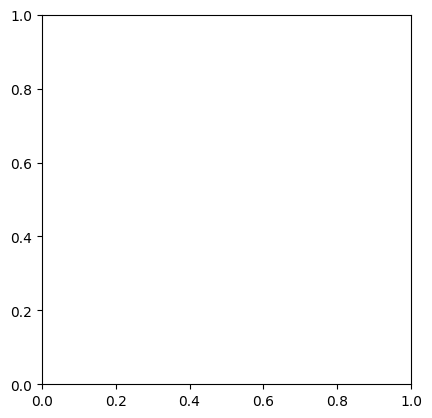

In [8]:
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

for img, label in dataloaders["train"]:
  transform = torchvision.transforms.ToPILImage()
  image = transform(img[0])
  imgplot = plt.imshow(image)
  break

In [ ]:
def train_model(model, criterion, optimizer, scheduler, device, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in tqdm(dataloaders[phase]):
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

In [ ]:

model_ft = models.regnet_x_800mf(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, len(all_data.classes))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, device,
                       num_epochs=5)

Epoch 0/4
----------


100%|██████████| 5144/5144 [16:49<00:00,  5.09it/s]


train Loss: 0.2048 Acc: 0.9446


100%|██████████| 2572/2572 [08:47<00:00,  4.88it/s]


val Loss: 0.0257 Acc: 0.9936

Epoch 1/4
----------


100%|██████████| 5144/5144 [03:01<00:00, 28.42it/s]


train Loss: 0.0532 Acc: 0.9874


100%|██████████| 2572/2572 [00:47<00:00, 54.46it/s]


val Loss: 0.0261 Acc: 0.9943

Epoch 2/4
----------


100%|██████████| 5144/5144 [03:02<00:00, 28.24it/s]


train Loss: 0.0332 Acc: 0.9916


100%|██████████| 2572/2572 [00:47<00:00, 54.57it/s]


val Loss: 0.0381 Acc: 0.9925

Epoch 3/4
----------


100%|██████████| 5144/5144 [03:02<00:00, 28.12it/s]


train Loss: 0.0229 Acc: 0.9950


100%|██████████| 2572/2572 [00:47<00:00, 54.06it/s]


val Loss: 0.0138 Acc: 0.9970

Epoch 4/4
----------


100%|██████████| 5144/5144 [03:02<00:00, 28.17it/s]


train Loss: 0.0195 Acc: 0.9954


100%|██████████| 2572/2572 [00:47<00:00, 54.49it/s]


val Loss: 0.0567 Acc: 0.9947

Training complete in 40m 55s
Best val Acc: 0.996987


In [ ]:
torch.save(model_ft.state_dict(), "/content/drive/MyDrive/model.pth")

In [ ]:
def test_model(model):
    running_loss = 0.0
    running_corrects = 0
    with torch.no_grad():
      for inputs, labels in tqdm(dataloaders['test']):
          inputs = inputs.to(device)
          labels = labels.to(device)
          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)
          loss = criterion(outputs, labels)
              # statistics
          running_loss += loss.item() * inputs.size(0)
          running_corrects += torch.sum(preds == labels.data)

      epoch_loss = running_loss / dataset_sizes["test"]
      epoch_acc = running_corrects.double() / dataset_sizes["test"]
      print(f'"test" Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

      print()

In [ ]:
from ast import mod
MODEL_DIR = "/content/drive/MyDrive/model.pth"
model_ft = models.regnet_x_800mf()
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, len(all_data.classes))
model_ft = model_ft.to(device)
model_ft.load_state_dict(torch.load(MODEL_DIR))
print(model_ft.eval())
print(model_ft)

RegNet(
  (stem): SimpleStemIN(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (trunk_output): Sequential(
    (block1): AnyStage(
      (block1-0): ResBottleneckBlock(
        (proj): Conv2dNormActivation(
          (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(2, 2), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (f): BottleneckTransform(
          (a): Conv2dNormActivation(
            (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (b): Conv2dNormActivation(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=4, bias=False)
            

In [ ]:
test_model(model_ft)

100%|██████████| 2572/2572 [08:32<00:00,  5.02it/s]

"test" Loss: 0.0126 Acc: 0.9963

